In [1]:
# Modify the file 00_setup.py to define input/output file paths on your system
# The information in 00_setup.py will be used across notebooks
from importlib.machinery import SourceFileLoader
setup = SourceFileLoader("setup", "./00_setup.py").load_module()

# XGBoost Alternate Mean Encoding
Re-do mean encodings, just mapping in means with no mixing

*This script takes about 5 minutes on my MacBook Air*

In [2]:
import pandas as pd
import numpy as np
import xgboost as xgb
import warnings
import matplotlib.pyplot as plt
import pickle
from matplotlib import cm, colors

In [3]:
from pathlib import Path

In [4]:
import sklearn as sk
from sklearn.model_selection import RandomizedSearchCV
from sklearn.inspection import permutation_importance, partial_dependence
from scikitplot.metrics import plot_lift_curve

In [5]:
from sba_gnn.sba_gnn import sg_plot 

## Import Processed Datasets

In [6]:
sba_loans = pd.read_parquet(Path(setup.temp_path).joinpath('01_DATA_transformed.parquet'))

In [7]:
train_df = sba_loans[sba_loans['dset'] == 'train'].copy()
test_df = sba_loans[sba_loans['dset'] == 'test']
val_df = sba_loans[sba_loans['dset'] == 'val']

In [8]:
train_df.shape

(425594, 50)

In [9]:
train_df.drop_duplicates('LoanNr_ChkDgt').shape

(425594, 50)

##### Remap mean encodings

In [10]:
train_vol_df = train_df.groupby('NAICS')['target'].agg(['mean', 'count'])

In [11]:
# Tried different thresholds - actually no threshold works best!
train_vol_df = train_vol_df[train_vol_df['count'] >= 1] \
    .reset_index() \
    .rename(columns={'mean':'menc_NAICS'})

In [12]:
sba_loans = sba_loans.drop(columns='menc_NAICS') \
    .merge(train_vol_df[['NAICS', 'menc_NAICS']], how='left', on='NAICS')

In [13]:
sba_loans['menc_NAICS'].isna().value_counts()

menc_NAICS
False    654745
True      33336
Name: count, dtype: int64

#### Set the predictor features.  Inlcude the new mean encoding

In [14]:
predictor_features = setup.predictor_features + ['menc_NAICS', 'cenc_NAICS']

print(predictor_features)

['NoEmp', 'CreateJob', 'LowDoc', 'DisbursementGross', 'new_business', 'urban_flag', 'franchise_flag', 'menc_NAICS', 'cenc_NAICS']


In [15]:
train_df[predictor_features].describe()

,NoEmp,CreateJob,LowDoc,DisbursementGross,new_business,urban_flag,franchise_flag,menc_NAICS,cenc_NAICS
count,425594.000000,425594.000000,422477.000000,4.255940e+05,425050.000000,342255.000000,425594.000000,425594.000000,425594.000000
mean,9.758920,2.172277,0.097807,1.949280e+05,0.279906,0.814930,0.050858,0.202996,0.007464
std,63.011166,15.140139,0.297053,2.994808e+05,0.448953,0.388355,0.219709,0.097416,0.010010
min,0.000000,0.000000,0.000000,4.000000e+03,0.000000,0.000000,0.000000,0.000000,0.000002
25%,2.000000,0.000000,0.000000,3.600000e+04,0.000000,1.000000,0.000000,0.123920,0.001116
50%,4.000000,0.000000,0.000000,9.000000e+04,0.000000,1.000000,0.000000,0.199369,0.003696
75%,9.000000,2.000000,0.000000,2.157000e+05,1.000000,1.000000,0.000000,0.269443,0.008990
max,9992.000000,5621.000000,1.000000,1.144632e+07,1.000000,1.000000,1.000000,1.000000,0.042806


In [16]:
train_df[predictor_features + ['target']].corr()

,NoEmp,CreateJob,LowDoc,DisbursementGross,new_business,urban_flag,franchise_flag,menc_NAICS,cenc_NAICS,target
NoEmp,1.000000,0.052510,-0.009243,0.093125,-0.038672,0.002058,0.006517,-0.025831,0.004918,-0.027838
CreateJob,0.052510,1.000000,-0.046967,0.101755,0.028831,0.009019,0.036918,0.003105,0.044666,-0.009540
LowDoc,-0.009243,-0.046967,1.000000,-0.133731,0.154037,-0.119292,0.039258,-0.077376,0.029143,-0.076836
DisbursementGross,0.093125,0.101755,-0.133731,1.000000,-0.067410,-0.006023,0.082087,-0.193132,-0.000219,-0.122857
new_business,-0.038672,0.028831,0.154037,-0.067410,1.000000,-0.046626,0.136142,0.026626,0.102731,0.014277
urban_flag,0.002058,0.009019,-0.119292,-0.006023,-0.046626,1.000000,-0.004093,0.061272,-0.001757,0.054391
franchise_flag,0.006517,0.036918,0.039258,0.082087,0.136142,-0.004093,1.000000,0.032178,0.178588,-0.011047
menc_NAICS,-0.025831,0.003105,-0.077376,-0.193132,0.026626,0.061272,0.032178,1.000000,-0.014748,0.242867
cenc_NAICS,0.004918,0.044666,0.029143,-0.000219,0.102731,-0.001757,0.178588,-0.014748,1.000000,-0.003697
target,-0.027838,-0.009540,-0.076836,-0.122857,0.014277,0.054391,-0.011047,0.242867,-0.003697,1.000000


In [17]:
with open(Path(setup.temp_path).joinpath('09_DATA_features_predict.pkl'), 'wb') as fout:
    pickle.dump(predictor_features, fout)

## Model Fit

In [18]:
best_params_df = pd.read_csv(Path(setup.temp_path).joinpath('03_REPORT_fit_parameter_selected.csv'))
best_params = best_params_df.to_dict(orient='records')[0]
best_params

{'subsample': 0.8,
 'scale_pos_weight': 1.0,
 'reg_lambda': 0.01,
 'reg_alpha': 0.001,
 'min_child_weight': 50,
 'max_depth': 8,
 'learning_rate': 0.1,
 'gamma': 2}

##### Fit using pre-determined parameters

In [19]:
xgb_params = dict(best_params, 
                   **{'objective':"binary:logistic", 'n_estimators':setup.xgb_n_estimators})

In [20]:
xgb_model = xgb.XGBClassifier(objective="binary:logistic",
                             n_estimators =  setup.xgb_n_estimators)

In [21]:
xgb_model = xgb_model.set_params(**xgb_params)

In [22]:
xgb_model.fit(train_df[predictor_features], train_df['target'],
              eval_set = [(train_df[predictor_features], train_df['target']),
                         (val_df[predictor_features], val_df['target'])])

[0]	validation_0-logloss:0.49811	validation_1-logloss:0.50112
[1]	validation_0-logloss:0.49045	validation_1-logloss:0.49356
[2]	validation_0-logloss:0.48406	validation_1-logloss:0.48722
[3]	validation_0-logloss:0.47866	validation_1-logloss:0.48188
[4]	validation_0-logloss:0.47394	validation_1-logloss:0.47728
[5]	validation_0-logloss:0.46995	validation_1-logloss:0.47335
[6]	validation_0-logloss:0.46660	validation_1-logloss:0.47009
[7]	validation_0-logloss:0.46373	validation_1-logloss:0.46729
[8]	validation_0-logloss:0.46121	validation_1-logloss:0.46484
[9]	validation_0-logloss:0.45901	validation_1-logloss:0.46274
[10]	validation_0-logloss:0.45716	validation_1-logloss:0.46096
[11]	validation_0-logloss:0.45545	validation_1-logloss:0.45935
[12]	validation_0-logloss:0.45408	validation_1-logloss:0.45807
[13]	validation_0-logloss:0.45283	validation_1-logloss:0.45696
[14]	validation_0-logloss:0.45171	validation_1-logloss:0.45592
[15]	validation_0-logloss:0.45077	validation_1-logloss:0.45506
[1

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=2, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=50, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=30, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [23]:
train_df['target'].value_counts()

target
0    339167
1     86427
Name: count, dtype: int64

##### Save the model

In [24]:
xgb_model.save_model(Path(setup.temp_path).joinpath('09_MODEL_xgboost.json'))

In [25]:
with open(Path(setup.temp_path).joinpath('09_MODEL_xgboost.pkl'), 'wb') as po:
    pickle.dump(xgb_model, po)

## Probability Predictions

In [26]:
pred_df = pd.concat([sba_loans[['LoanNr_ChkDgt', 'dset', 'target', 'dset_naics_holdout']].reset_index(),
                     pd.DataFrame({'predict_prob':
                                   xgb_model.predict_proba(sba_loans[predictor_features])[:,1]})],
                    axis=1) \
    .set_index('index')

In [27]:
pred_df.groupby('target')['predict_prob'].agg(['mean', 'std', 'min', 'max', 'median'])

,mean,std,min,max,median
target,,,,,
0,0.191499,0.124446,0.016716,0.666890,0.176431
1,0.293952,0.118498,0.017457,0.680927,0.293570


## Decision Threshold
Max f1, on training data

In [28]:
pred_train_df = pred_df[pred_df['dset'] == 'train']

In [29]:
thresh_tune_data = sg_plot.get_f1_frame(pred_train_df['target'], 
                                        pred_train_df['predict_prob'])

In [30]:
thresh_tune_data.to_csv(Path(setup.temp_path).joinpath('09_REPORT_thresh_tune.csv'), index=False)

In [31]:
thresh_head = thresh_tune_data.sort_values('f1', ascending=False).head(2)
best_thresh = thresh_head['thresh'].iloc[0]
print(best_thresh)
thresh_head

0.24


,thresh,f1
12,0.24,0.454248
11,0.22,0.453889


##### Apply decision threshold
All datasets

In [32]:
pred_df['predict_bin'] = np.where(pred_df['predict_prob'] >= best_thresh, 1, 0)

In [33]:
pred_df['predict_bin'].value_counts()

predict_bin
0    399517
1    288564
Name: count, dtype: int64

In [34]:
pred_df.to_parquet(Path(setup.temp_path).joinpath('09_DATA_combined_predictions.parquet'))

## Metrics

In [35]:
metrics_dset_df = pred_df.groupby('dset') \
    .apply(lambda x: sg_plot.dset_metrics(x.target, x.predict_bin, x.predict_prob)) \
    .reset_index()
metrics_test_df = pred_df[pred_df['dset'] == 'test'] \
    .groupby(['dset', 'dset_naics_holdout']) \
    .apply(lambda x: sg_plot.dset_metrics(x.target, x.predict_bin, x.predict_prob)) \
    .reset_index()
metrics_df = pd.concat([metrics_dset_df, metrics_test_df])
metrics_df.to_csv(Path(setup.temp_path).joinpath('09_REPORT_metrics.csv'), index=True)
metrics_df

,dset,accuracy_score,f1_score,precision_score,recall_score,average_precision_score,roc_auc_score,dset_naics_holdout
0,test,0.614910,0.430911,0.306183,0.727110,0.327175,0.701848,NaN
1,train,0.667827,0.454248,0.340845,0.680736,0.392901,0.737834,NaN
2,val,0.666878,0.453884,0.342245,0.673616,0.387681,0.732730,NaN
0,test,0.666415,0.451366,0.339393,0.673601,0.391046,0.732518,0.0
1,test,0.455509,0.387619,0.246692,0.904110,0.336197,0.709319,1.0


## Lift
Test data

In [36]:
pred_test_df = pred_df[pred_df['dset'] == 'test']

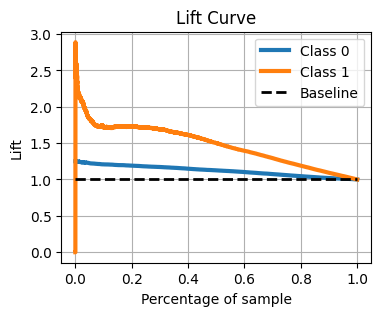

In [37]:
plot_lift_curve(pred_test_df['target'], 
                pd.concat([1-pred_test_df['predict_prob'], pred_test_df['predict_prob']], axis=1), 
                title='Lift Curve', ax=None, figsize=(4,3), 
                title_fontsize='large', text_fontsize='medium')
plt.gca().legend(loc='upper right')
plt.gcf().savefig(Path(setup.temp_path).joinpath('09_PLOT_lift_curve.png'),bbox_inches='tight')

## Feature Importance 

##### XGBoost gain

In [38]:
feat_impgain = pd.DataFrame(xgb_model.get_booster().get_score(importance_type='gain'),
                                     index=['importance']).T \
    .sort_values('importance', ascending=False)

In [39]:
feat_impgain.to_csv(Path(setup.temp_path).joinpath('09_REPORT_importance_gain.csv'), index=True)

In [40]:
feat_impgain.head()

,importance
urban_flag,281.128815
menc_NAICS,127.659485
LowDoc,117.845795
DisbursementGross,53.033443
franchise_flag,19.944201


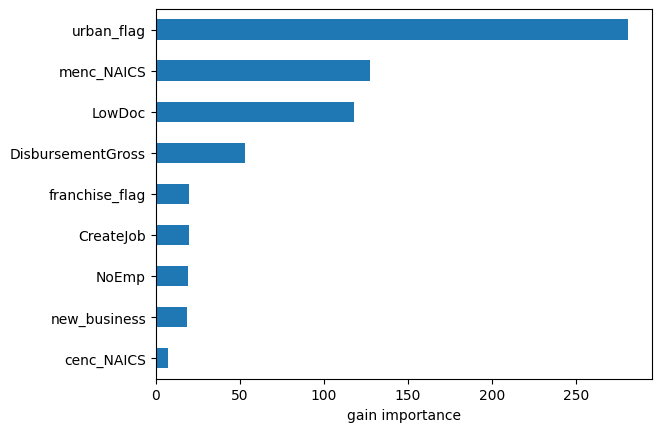

In [41]:
feat_impgain.plot(kind='barh', legend=None)
plt.gca().invert_yaxis()
plt.xlabel('gain importance')
plt.gcf().savefig(Path(setup.temp_path).joinpath('09_PLOT_importance_gain.png'))

##### Permutation Importance

In [42]:
perm_importance = permutation_importance(xgb_model, 
                                         train_df[predictor_features],  train_df['target'],
                                         n_repeats=30, scoring = 'average_precision')

In [43]:
perm_importance_df = pd.DataFrame({'features':predictor_features,
                                   'importance': perm_importance['importances_mean']}) 
perm_importance_df['abs_importance'] = np.abs(perm_importance_df['importance'])
perm_importance_df = perm_importance_df.sort_values('abs_importance', ascending=False)

In [44]:
perm_importance_df.head(5)

,features,importance,abs_importance
7,menc_NAICS,0.089819,0.089819
3,DisbursementGross,0.064461,0.064461
5,urban_flag,0.035875,0.035875
1,CreateJob,0.019845,0.019845
2,LowDoc,0.014286,0.014286


In [45]:
perm_importance_df \
    .to_csv(Path(setup.temp_path).joinpath('09_DATA_importance_perturb.csv'),
            index=False)

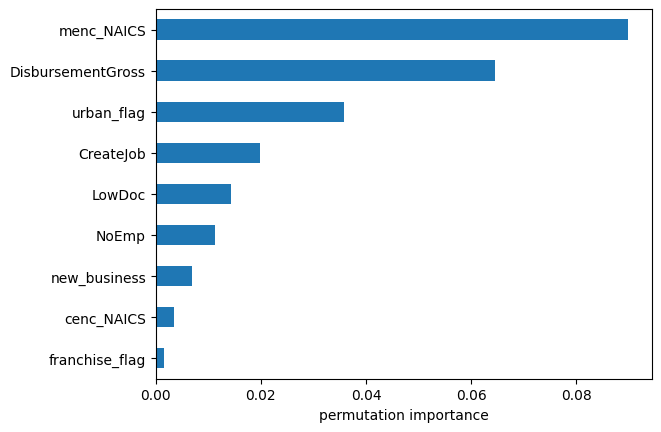

In [46]:
perm_importance_df.head(10).plot(kind='barh', x='features', y='importance', legend=None)
plt.gca().invert_yaxis()
plt.xlabel('permutation importance')
plt.ylabel(None)
plt.gcf().savefig(Path(setup.temp_path).joinpath('09_PLOT_importance_perturb.png'))

## PDP Plot - NAICS mean encoded

In [50]:
results = partial_dependence(xgb_model, train_df[predictor_features], ['menc_NAICS', 'cenc_NAICS'],
                            grid_resolution=25)

In [52]:
plt.close()

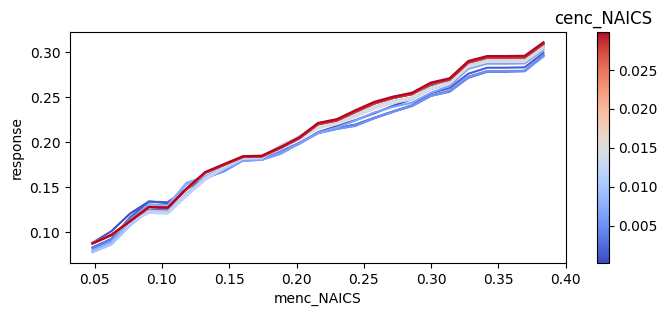

In [53]:
fig, ax = plt.subplots(figsize = (8, 3))
pdp_df.plot(legend=None, cmap = 'coolwarm', ax=ax)
ax.set_xlabel('menc_NAICS')
ax.set_ylabel('response')
norm = colors.Normalize(np.min(results["grid_values"][1]), 
                       np.max(results["grid_values"][1]))
clb = plt.colorbar(cm.ScalarMappable(cmap = 'coolwarm', norm=norm), ax=ax)
clb.ax.set_title('cenc_NAICS')
fig.savefig(Path(setup.temp_path).joinpath('09_PLOT_pdp_naics_mean_count_enc.png'),
               bbox_inches='tight')

##### 2-way PDP with count encoding

In [50]:
results = partial_dependence(xgb_model, train_df[predictor_features], ['menc_NAICS', 'cenc_NAICS'],
                            grid_resolution=25)

In [51]:
pdp_df = pd.DataFrame(results["average"][0],
                      index=results["grid_values"][0],
                      columns = results["grid_values"][1])

In [52]:
plt.close()

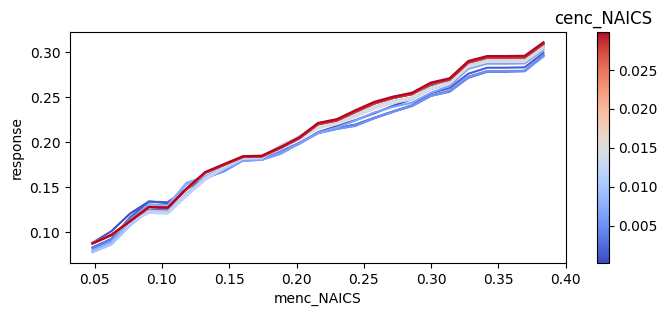

In [53]:
fig, ax = plt.subplots(figsize = (8, 3))
pdp_df.plot(legend=None, cmap = 'coolwarm', ax=ax)
ax.set_xlabel('menc_NAICS')
ax.set_ylabel('response')
norm = colors.Normalize(np.min(results["grid_values"][1]), 
                       np.max(results["grid_values"][1]))
clb = plt.colorbar(cm.ScalarMappable(cmap = 'coolwarm', norm=norm), ax=ax)
clb.ax.set_title('cenc_NAICS')
fig.savefig(Path(setup.temp_path).joinpath('09_PLOT_pdp_naics_mean_count_enc.png'),
               bbox_inches='tight')